In [1]:
import pandas as pd
import os, sys
import numpy as np

sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '../../..')))

from utils.prediction_utils import *

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import plot_tree

from sklearn.ensemble import RandomForestRegressor

import xgboost as xgb

random_seed = 42

# Load Data

In [2]:
base_dir = "/Users/andrew/Desktop/Harvard/idreos-research/gpu_profiling"
X, y = get_data("mm", base_dir, sample_rate=1.0)
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1247616 entries, 0 to 1247615
Data columns (total 7 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   n          1247616 non-null  int64  
 1   m          1247616 non-null  int64  
 2   p          1247616 non-null  int64  
 3   gflops     1247616 non-null  float64
 4   dtype_16   1247616 non-null  bool   
 5   dtype_32   1247616 non-null  bool   
 6   dtype_b16  1247616 non-null  bool   
dtypes: bool(3), float64(1), int64(3)
memory usage: 41.6 MB


# Train-Test-Split

In [3]:
X_train, X_val, X_test, y_train, y_val, y_test = get_train_test_split(X, y, return_concat = False)
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 873331 entries, 532472 to 121958
Data columns (total 7 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   n          873331 non-null  int64  
 1   m          873331 non-null  int64  
 2   p          873331 non-null  int64  
 3   gflops     873331 non-null  float64
 4   dtype_16   873331 non-null  bool   
 5   dtype_32   873331 non-null  bool   
 6   dtype_b16  873331 non-null  bool   
dtypes: bool(3), float64(1), int64(3)
memory usage: 35.8 MB


# Fitting

## Decision tree

Much better than linreg!

Seems to use the wrong splits! Ideally, split off of dtype.
Note: for low # of max splits, high r^2 AND high MSE because of large range of values

In [4]:
tree_model = DecisionTreeRegressor(max_depth=10, random_state=random_seed)
tree_model.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=10, random_state=42)

Train--------
Mean Squared Error: 0.8147532144969561
R-squared: 0.9999434994071629


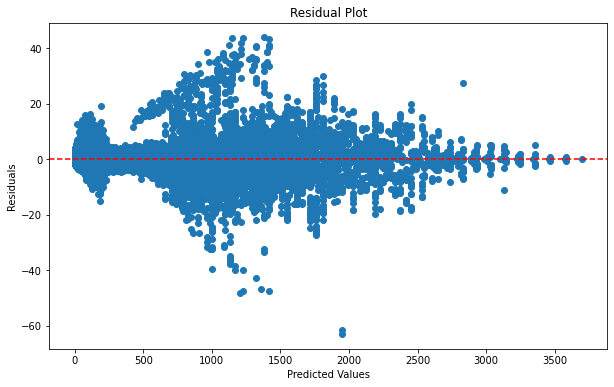

Val--------
Mean Squared Error: 1.099482071504874
R-squared: 0.9999216835167678


In [8]:
y_hat_train = tree_model.predict(X_train)
y_hat_val = tree_model.predict(X_val)

print("Train--------")
get_r2_score(y_train, y_hat_train)
plot_residuals(y_train, y_hat_train)

print("Val--------")
_ = get_r2_score(y_val, y_hat_val)

# plot_residuals(y_val, y_hat_val)

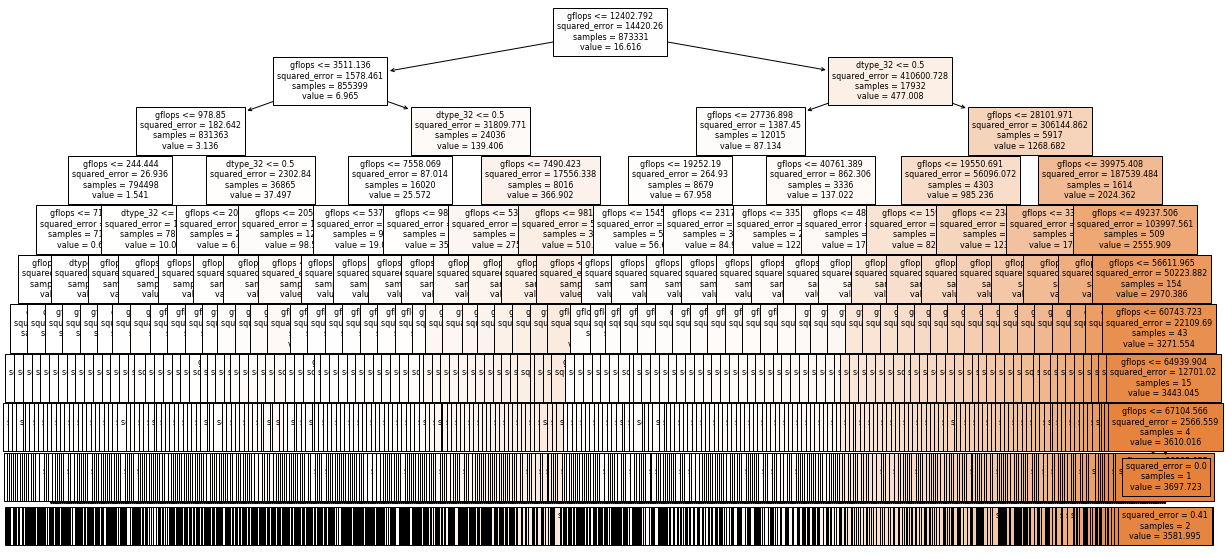

In [9]:
plt.figure(figsize=(20,10))
plot_tree(tree_model, filled=True, feature_names=X_train.columns, fontsize=8)
plt.show()

In [10]:
feature_importances = tree_model.feature_importances_

# Create a DataFrame to view the features and their importance scores
features_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importances
})

# Sort the DataFrame to show more important features at the top
features_df = features_df.sort_values(by='Importance', ascending=False)

# Print the DataFrame
print(features_df)

     Feature  Importance
3     gflops    0.504595
5   dtype_32    0.495299
1          m    0.000060
2          p    0.000022
0          n    0.000022
4   dtype_16    0.000001
6  dtype_b16    0.000001


## XGBoost with MAPE

In [75]:
def mape_eval(y_pred, dtrain):
    y_true = dtrain.get_label()
    # Avoid division by zero and set lower bound to a small number
    epsilon = 1e-8
    y_true = np.maximum(y_true, epsilon)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return 'mape', mape

# Prepare data
dtrain = xgb.DMatrix(X_train_encoded, label=y_train)
dval = xgb.DMatrix(X_val_encoded, label=y_val)

# Set up parameters
params = {
    'max_depth': 10,
    'eta': 0.1,
    'silent': 1,
    'objective': 'reg:squarederror'
}

# Train the model with custom MAPE evaluation
evals_result = {}
model = xgb.train(params, dtrain, num_boost_round=100,
                  evals=[(dtrain, 'train'), (dval, 'eval')],
                  feval=mape_eval, evals_result=evals_result,
                  early_stopping_rounds=10)

# Output final MAPE scores from evaluation
print("Final Training MAPE:", evals_result['train']['mape'][-1])
print("Final Validation MAPE:", evals_result['eval']['mape'][-1])

[0]	train-rmse:108.36227	train-mape:28805.14526	eval-rmse:107.46305	eval-mape:28732.61414
[1]	train-rmse:97.66951	train-mape:25926.10169	eval-rmse:96.82976	eval-mape:25860.83069
[2]	train-rmse:88.04383	train-mape:23335.58350	eval-rmse:87.24260	eval-mape:23276.84174
[3]	train-rmse:79.38285	train-mape:21004.46777	eval-rmse:78.65294	eval-mape:20951.59607


/opt/miniconda3/envs/research/lib/python3.10/site-packages/xgboost/training.py:38: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
  warnings.warn(
/opt/miniconda3/envs/research/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [17:03:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[4]	train-rmse:71.58845	train-mape:18905.22461	eval-rmse:70.93054	eval-mape:18857.65076
[5]	train-rmse:64.57667	train-mape:17015.88898	eval-rmse:63.97882	eval-mape:16973.06824
[6]	train-rmse:58.27008	train-mape:15315.18555	eval-rmse:57.78340	eval-mape:15276.65100
[7]	train-rmse:52.59555	train-mape:13785.33325	eval-rmse:52.17749	eval-mape:13750.65308
[8]	train-rmse:47.48805	train-mape:12407.58820	eval-rmse:47.11725	eval-mape:12376.37711
[9]	train-rmse:42.89644	train-mape:11167.58499	eval-rmse:42.60401	eval-mape:11139.48975
[10]	train-rmse:38.76753	train-mape:10051.69525	eval-rmse:38.52393	eval-mape:10026.41067
[11]	train-rmse:35.05333	train-mape:9047.49069	eval-rmse:34.86730	eval-mape:9024.73755
[12]	train-rmse:31.71659	train-mape:8143.59818	eval-rmse:31.59322	eval-mape:8123.12393
[13]	train-rmse:28.71780	train-mape:7329.76685	eval-rmse:28.64290	eval-mape:7311.34033
[14]	train-rmse:26.02105	train-mape:6597.28851	eval-rmse:25.97121	eval-mape:6580.70831
[15]	train-rmse:23.60213	train-mape

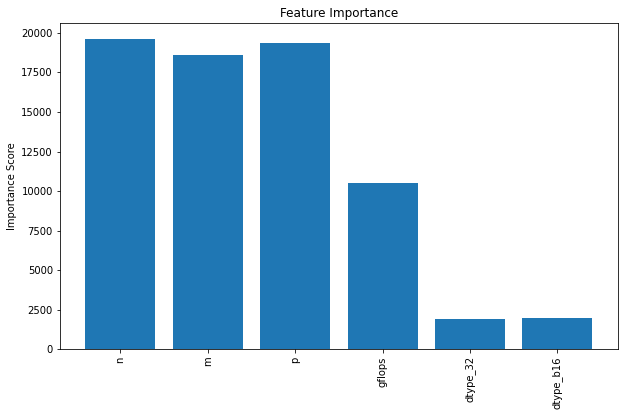

In [76]:
# Get feature importances
feature_importances = model.get_score(importance_type='weight')

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.bar(range(len(feature_importances)), list(feature_importances.values()), align='center')
plt.xticks(range(len(feature_importances)), list(feature_importances.keys()), rotation='vertical')
plt.title('Feature Importance')
plt.ylabel('Importance Score')
plt.show()

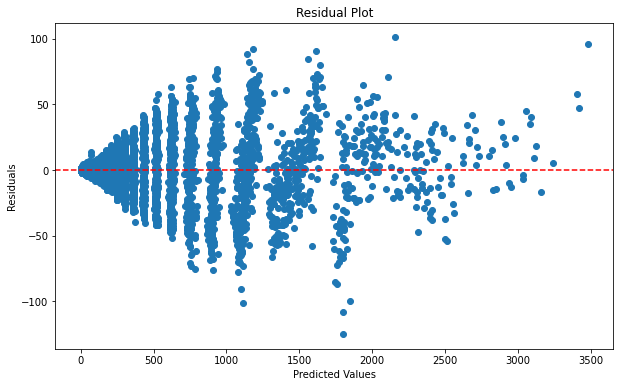

In [77]:
y_pred = model.predict(dval)
residuals = y_val - y_pred

plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals)
plt.title('Residual Plot')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()